In [1]:
%pip install torch torchvision torchsummary
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import json
import os
from MiraBest_Goof import MiraBest

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5]),
     transforms.RandomHorizontalFlip(0.5)])

In [3]:
trainset = MiraBest(root='../batches', train=True, download=True, transform=transform)  
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset = MiraBest(root='../batches', train=False, download=True, transform=transform) 
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataset_sizes = {"train": 693, "test": 77}

In [57]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.conv3 = nn.Conv2d(3, 6, 3)
        # self.fc1 = nn.Linear(16 * 73 * 73, 120) 
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(6*17*17, 2) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, 6*17*17)
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [86]:
net = Net()
summary(net,(1,150,150))
loss = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 148, 148]              30
            Conv2d-2            [-1, 3, 72, 72]              84
            Conv2d-3            [-1, 6, 34, 34]             168
            Linear-4                    [-1, 2]           3,470
Total params: 3,752
Trainable params: 3,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.67
Params size (MB): 0.01
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


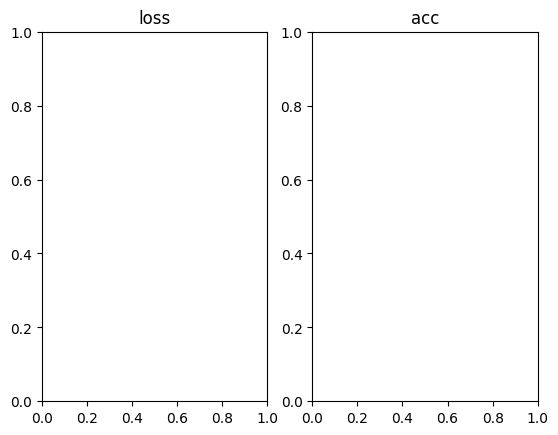

In [87]:
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="acc")

y_loss = {}
y_loss["train"] = []
y_loss["test"] = []
y_acc = {}
y_acc["train"] = []
y_acc["test"] = []
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

def draw_curve(directory):
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['test'], 'ro-', label='test')
    ax1.plot(x_epoch, y_acc['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_acc['test'], 'ro-', label='test')
    file_name = "train_" + str(len(x_epoch)) + ".jpg"
    fig.savefig(os.path.join(directory, file_name))

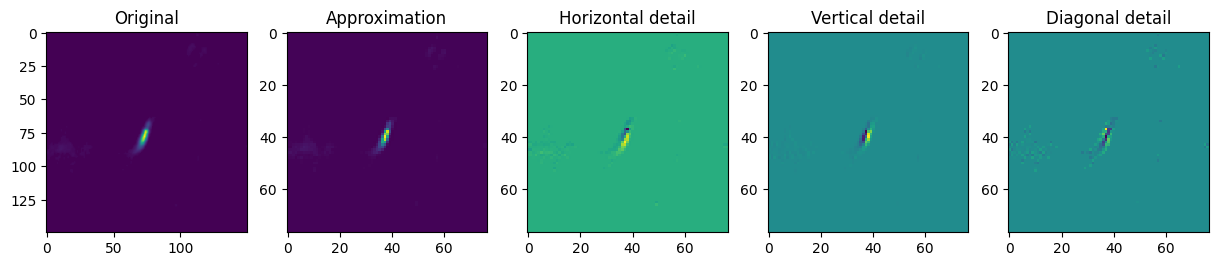

In [20]:
import pywt
for i, data in enumerate(trainset, 0):
    images, labels = data
    for image in images:
        coeffs2 = pywt.dwt2(image, 'bior1.3')
        LL, (LH, HL, HH) = coeffs2

        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1,5,1)
        ax2 = fig.add_subplot(1,5,2)
        ax3 = fig.add_subplot(1,5,3)
        ax4 = fig.add_subplot(1,5,4)
        ax5 = fig.add_subplot(1,5,5)
        
        ax1.imshow(image)
        ax1.set_title("Original")
        ax2.imshow(LL, interpolation="nearest") 
        ax2.set_title("Approximation")
        ax3.imshow(LH, interpolation="nearest") 
        ax3.set_title("Horizontal detail")
        ax4.imshow(HL, interpolation="nearest") 
        ax4.set_title("Vertical detail")
        ax5.imshow(HH, interpolation="nearest") 
        ax5.set_title("Diagonal detail")
        plt.show()
    break

In [56]:
#approximation
print("Approximation")
x_epoch = []
num_epochs = 40
for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = LL # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = LL # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}:\nloss: {:.4f} | accuracy: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
        if(epoch % 5 == 1):
            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)
        if(phase == "test" and epoch % 5 == 1):
            x_epoch.append(epoch)
            draw_curve('../lossGraphs_v2_approximation')
        

Approximation
----------
Epoch 1/40
TRAIN:
loss: 0.6930 | accuracy: 0.5253
TEST:
loss: 0.6942 | accuracy: 0.5584
----------
Epoch 2/40
TRAIN:
loss: 0.6760 | accuracy: 0.5786
TEST:
loss: 0.6453 | accuracy: 0.6883
----------
Epoch 3/40
TRAIN:
loss: 0.6539 | accuracy: 0.6537
TEST:
loss: 0.6152 | accuracy: 0.7273
----------
Epoch 4/40
TRAIN:
loss: 0.6303 | accuracy: 0.6696
TEST:
loss: 0.5749 | accuracy: 0.7403
----------
Epoch 5/40
TRAIN:
loss: 0.6118 | accuracy: 0.6739
TEST:
loss: 0.5545 | accuracy: 0.7403
----------
Epoch 6/40
TRAIN:
loss: 0.5943 | accuracy: 0.6681
TEST:
loss: 0.5613 | accuracy: 0.7143
----------
Epoch 7/40
TRAIN:
loss: 0.5739 | accuracy: 0.6941
TEST:
loss: 0.5596 | accuracy: 0.6494
----------
Epoch 8/40
TRAIN:
loss: 0.5680 | accuracy: 0.6869
TEST:
loss: 0.5752 | accuracy: 0.6753
----------
Epoch 9/40
TRAIN:
loss: 0.5604 | accuracy: 0.7100
TEST:
loss: 0.5577 | accuracy: 0.6883
----------
Epoch 10/40
TRAIN:
loss: 0.5418 | accuracy: 0.7316
TEST:
loss: 0.5687 | accuracy: 0.

In [60]:
#horizontal
print("Horizontal")
x_epoch = []
num_epochs = 40
for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = LH # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = LH # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}:\nloss: {:.4f} | accuracy: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
        if(epoch % 5 == 1):
            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)
        if(phase == "test" and epoch % 5 == 1):
            x_epoch.append(epoch)
            draw_curve('../lossGraphs_v3_horizontal')
        

Horizontal
----------
Epoch 1/40
TRAIN:
loss: 0.7065 | accuracy: 0.5368
TEST:
loss: 0.6868 | accuracy: 0.5584
----------
Epoch 2/40
TRAIN:
loss: 0.6913 | accuracy: 0.5426
TEST:
loss: 0.6961 | accuracy: 0.5584
----------
Epoch 3/40
TRAIN:
loss: 0.6820 | accuracy: 0.5772
TEST:
loss: 0.6575 | accuracy: 0.5584
----------
Epoch 4/40
TRAIN:
loss: 0.6621 | accuracy: 0.6176
TEST:
loss: 0.6386 | accuracy: 0.5974
----------
Epoch 5/40
TRAIN:
loss: 0.6491 | accuracy: 0.6190
TEST:
loss: 0.6137 | accuracy: 0.7143
----------
Epoch 6/40
TRAIN:
loss: 0.6317 | accuracy: 0.6739
TEST:
loss: 0.6047 | accuracy: 0.7013
----------
Epoch 7/40
TRAIN:
loss: 0.6123 | accuracy: 0.6912
TEST:
loss: 0.5811 | accuracy: 0.7143
----------
Epoch 8/40
TRAIN:
loss: 0.6052 | accuracy: 0.6811
TEST:
loss: 0.5749 | accuracy: 0.7143
----------
Epoch 9/40
TRAIN:
loss: 0.5927 | accuracy: 0.7042
TEST:
loss: 0.5639 | accuracy: 0.7532
----------
Epoch 10/40
TRAIN:
loss: 0.5854 | accuracy: 0.7143
TEST:
loss: 0.5702 | accuracy: 0.714

In [66]:
#vertical
print("Vertical")
x_epoch = []
num_epochs = 40
for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = HL # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = HL # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}:\nloss: {:.4f} | accuracy: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
        if(epoch % 5 == 1):
            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)
        if(phase == "test" and epoch % 5 == 1):
            x_epoch.append(epoch)
            draw_curve('../lossGraphs_v4_vertical')
        

Vertical
----------
Epoch 1/40
TRAIN:
loss: 0.7016 | accuracy: 0.5310
TEST:
loss: 0.6870 | accuracy: 0.5584
----------
Epoch 2/40
TRAIN:
loss: 0.6895 | accuracy: 0.5570
TEST:
loss: 0.6884 | accuracy: 0.5584
----------
Epoch 3/40
TRAIN:
loss: 0.6888 | accuracy: 0.5599
TEST:
loss: 0.6880 | accuracy: 0.5584
----------
Epoch 4/40
TRAIN:
loss: 0.6881 | accuracy: 0.5599
TEST:
loss: 0.6867 | accuracy: 0.5584
----------
Epoch 5/40
TRAIN:
loss: 0.6865 | accuracy: 0.5628
TEST:
loss: 0.6869 | accuracy: 0.5584
----------
Epoch 6/40
TRAIN:
loss: 0.6869 | accuracy: 0.5599
TEST:
loss: 0.6868 | accuracy: 0.5584
----------
Epoch 7/40
TRAIN:
loss: 0.6848 | accuracy: 0.5599
TEST:
loss: 0.6849 | accuracy: 0.5584
----------
Epoch 8/40
TRAIN:
loss: 0.6838 | accuracy: 0.5599
TEST:
loss: 0.6838 | accuracy: 0.5584
----------
Epoch 9/40
TRAIN:
loss: 0.6824 | accuracy: 0.5599
TEST:
loss: 0.6826 | accuracy: 0.5584
----------
Epoch 10/40
TRAIN:
loss: 0.6821 | accuracy: 0.5584
TEST:
loss: 0.6815 | accuracy: 0.5584


In [69]:
#diagonal
print("Diagonal")
x_epoch = []
num_epochs = 40
for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = HH # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    image = HH # approximation
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}:\nloss: {:.4f} | accuracy: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
        if(epoch % 5 == 1):
            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)
        if(phase == "test" and epoch % 5 == 1):
            x_epoch.append(epoch)
            draw_curve('../lossGraphs_v5_diagonal')
        

Diagonal
----------
Epoch 1/40
TRAIN:
loss: 0.6945 | accuracy: 0.5584
TEST:
loss: 0.6877 | accuracy: 0.5584
----------
Epoch 2/40
TRAIN:
loss: 0.6869 | accuracy: 0.5570
TEST:
loss: 0.6818 | accuracy: 0.5584
----------
Epoch 3/40
TRAIN:
loss: 0.6810 | accuracy: 0.5844
TEST:
loss: 0.6771 | accuracy: 0.5844
----------
Epoch 4/40
TRAIN:
loss: 0.6697 | accuracy: 0.6205
TEST:
loss: 0.6604 | accuracy: 0.7143
----------
Epoch 5/40
TRAIN:
loss: 0.6566 | accuracy: 0.6782
TEST:
loss: 0.6250 | accuracy: 0.7792
----------
Epoch 6/40
TRAIN:
loss: 0.6343 | accuracy: 0.6869
TEST:
loss: 0.6050 | accuracy: 0.7532
----------
Epoch 7/40
TRAIN:
loss: 0.6149 | accuracy: 0.6926
TEST:
loss: 0.6063 | accuracy: 0.7143
----------
Epoch 8/40
TRAIN:
loss: 0.5992 | accuracy: 0.7027
TEST:
loss: 0.5977 | accuracy: 0.6753
----------
Epoch 9/40
TRAIN:
loss: 0.5848 | accuracy: 0.6883
TEST:
loss: 0.5795 | accuracy: 0.7403
----------
Epoch 10/40
TRAIN:
loss: 0.5581 | accuracy: 0.7345
TEST:
loss: 0.5662 | accuracy: 0.7143


In [88]:
#combined
print("Combined")
x_epoch = []
num_epochs = 50
for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                LL_batch, LH_batch, HL_batch, HH_batch = [], [], [], []
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    LL = torch.tensor(LL, dtype=torch.float32)
                    LH = torch.tensor(LH, dtype=torch.float32)
                    HL = torch.tensor(HL, dtype=torch.float32)
                    HH = torch.tensor(HH, dtype=torch.float32)
                    image =  torch.stack([LL, LH, HL, HH])
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                for image in images:
                    coeffs2 = pywt.dwt2(image, 'db1')
                    LL, (LH, HL, HH) = coeffs2
                    LL = torch.tensor(LL, dtype=torch.float32)
                    LH = torch.tensor(LH, dtype=torch.float32)
                    HL = torch.tensor(HL, dtype=torch.float32)
                    HH = torch.tensor(HH, dtype=torch.float32)
                    image =  torch.stack([LL, LH, HL, HH])
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}:\nloss: {:.4f} | accuracy: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
        if(epoch % 5 == 1):
            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)
        if(phase == "test" and epoch % 5 == 1):
            x_epoch.append(epoch)
            draw_curve('../lossGraphs_v6_combined')
        

Combined
----------
Epoch 1/50
TRAIN:
loss: 0.6936 | accuracy: 0.5541
TEST:
loss: 0.6863 | accuracy: 0.5584
----------
Epoch 2/50
TRAIN:
loss: 0.6873 | accuracy: 0.5599
TEST:
loss: 0.6865 | accuracy: 0.5584
----------
Epoch 3/50
TRAIN:
loss: 0.6874 | accuracy: 0.5599
TEST:
loss: 0.6664 | accuracy: 0.5584
----------
Epoch 4/50
TRAIN:
loss: 0.6651 | accuracy: 0.6075
TEST:
loss: 0.6399 | accuracy: 0.6883
----------
Epoch 5/50
TRAIN:
loss: 0.6445 | accuracy: 0.6768
TEST:
loss: 0.6094 | accuracy: 0.7403
----------
Epoch 6/50
TRAIN:
loss: 0.6210 | accuracy: 0.6825
TEST:
loss: 0.5834 | accuracy: 0.7403
----------
Epoch 7/50
TRAIN:
loss: 0.5983 | accuracy: 0.6768
TEST:
loss: 0.5716 | accuracy: 0.7143
----------
Epoch 8/50
TRAIN:
loss: 0.5852 | accuracy: 0.7013
TEST:
loss: 0.5724 | accuracy: 0.7013
----------
Epoch 9/50
TRAIN:
loss: 0.5641 | accuracy: 0.7114
TEST:
loss: 0.5546 | accuracy: 0.7403
----------
Epoch 10/50
TRAIN:
loss: 0.5602 | accuracy: 0.7085
TEST:
loss: 0.5300 | accuracy: 0.7403
